## MGMT573 Optimization Modeling with Spreadsheets
### Linear Programming: Allocation Problem

In [1]:
# conda install gurobi

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important! }</style>"))

In [3]:
import gurobipy as gp
from gurobipy import Model, GRB
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt

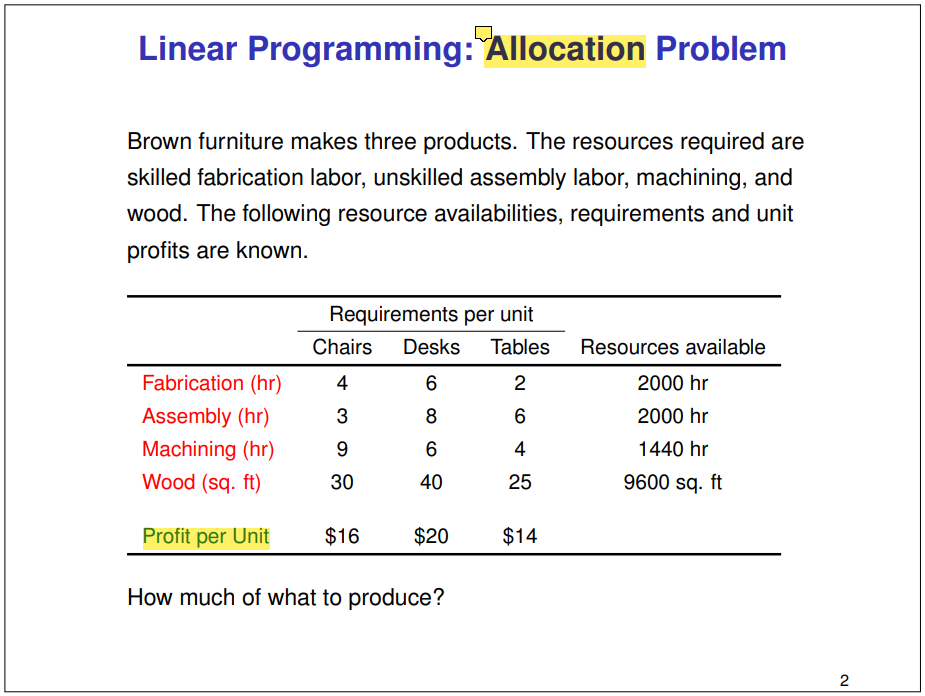

In [3]:
from IPython.display import Image
Image(filename='C:/Users/lilian/21_Purdue_Course/573 Opt/allocation.png',width=600, height=300)

In [4]:
m = Model("allocation")

Restricted license - for non-production use only - expires 2023-10-25


We now define the optimization model variables

Variable | Meaning
:---- | :----
$C$ | numner of chairs to produce
$D$ | numner of desks to produce
$T$ | numner of tables to produce

To declare a variallbe as interger and binary, use `vtype=GRB.INTEGER`
and `vtype=GRB.INARY` respectively.
We do not need such variables for this example.

In [5]:
# define variables
# >=0, no upper bound, does not have to be integers
C = m.addVar(lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name='C')
D = m.addVar(lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name='D')
T = m.addVar(lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name='T')

Now, we define the formulation:

<i></i> | objective/constraint   | meaning
:----   | :----               | ---:
max     |$16C+ 20D + 14T$ | profit
s.t.    | $4C + 6D + 2T \le 2000$ | fabrication
        | $3C + 8D + 6T \le 2000$ | assembly
        | $9C + 6D + 4T \le 1440$ | machining
        | $30C + 40D + 25T \le 9600$ | wood
        | $C, D, T \ge 0$         | non-negativeity

Observe that we have already defined the non-negativity constraints in the variable definition.

In [6]:
obj = m.setObjective(16*C + 20*D + 14*T, GRB.MAXIMIZE)
fabrication = m.addConstr(4*C + 6*D + 2*T <= 2000, name ='fabrication')
assembly = m.addConstr(3*C + 8*D + 6*T <= 2000, name = 'assembly')
machining = m.addConstr(9*C + 6*D + 4*T <= 1440, name='machining')
wood = m.addConstr(30*C + 40*D + 25*T <= 9600, name='Wood')

Now, we optimize

In [7]:
m.optimize() 

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4 rows, 3 columns and 12 nonzeros
Model fingerprint: 0x64395734
Coefficient statistics:
  Matrix range     [2e+00, 4e+01]
  Objective range  [1e+01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+04]
Presolve time: 0.00s
Presolved: 4 rows, 3 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.2500000e+30   7.328125e+30   8.250000e+00      0s
       4    4.8800000e+03   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.880000000e+03


Now, we probe the Gurobi variables to find the optimal objective value and the optimal values of the variables

In [8]:
# Print optimal objective and solution
if m.status == GRB.status.OPTIMAL:
    for v in m.getVars():
        print("{}: {:f}".format(v.varName, v.x))
    print("Obj: {:f}".format(m.objVal))

C: 0.000000
D: 160.000000
T: 120.000000
Obj: 4880.000000


We now set up the datastructure to retrieve sensitivity information

In [9]:
decision_var = OrderedDict([
    ('Name', []),
    ('Final Value', []),
    ('Reduced Cost', []),
    ('Objective Coefficient', []),
    ('Lower Coeff', []),
    ('Upper Coeff', []),
    ('Lower Bound', []),
    ('Upper Bound', [])
])
constraint = OrderedDict([
    ('Name', []),
    ('Shadow Price', []),
    ('RHS Coeff', []),
    ('Slack', []),
    ('Sense', []),
    ('Lower RHS', []),
    ('Upper RHS', [])
])

We loop over the variables in the model accumulating the following information:

Attribute | Meaning
:--- | :---
Name | name given to the variable in its definition
Final Value | optimal value for the variable
Reduced Cost | change in objective per unit change in any tight bound
Objective Coefficient | objective coefficient of the variable
Lower Coeff | smallest objective coefficient for optimal solution to stay optimal
Upper Coeff | largest objective coefficient for optimal solution to stay optimal
Lower Bound | lower bound for the variable
Upper Bound | upper bound for the variable

To read about the attributes associated with Variables and Constraints, visit  [this website](https://www.gurobi/com/documentation/9.0/refman/attributes/html).
To read about the list of functions in the API, read [this website](https://www.gurobi.com/documentation/9.0/refman/py_python_api_detail.html).

Remark: we do not need to loop over variables, because we already have access to variables C, D and T. Therefore, we could obtain the reduced cost using `C.RC`, the optimal value using `C.X`. But for the purpose of this demonstration, we will retrive everything from the memory.

In [10]:
# append list to empty list
for v in m.getVars():
    decision_var['Name'].append(v.varName)
    decision_var['Final Value'].append(v.X)
    decision_var['Reduced Cost'].append(v.RC)
    decision_var['Objective Coefficient'].append(v.Obj)
    decision_var['Lower Coeff'].append(v.SAObjLow)
    decision_var['Upper Coeff'].append(v.SAObjUp)
    decision_var['Lower Bound'].append(v.LB)
    decision_var['Upper Bound'].append(v.UB)

We now loop over the constraints finding the sensitivity information below:

Attribute | Meaning
:--- | :---
Name | name given to the constraint during its definition
Shadow Price | change in objective per unit change in the right hand side
RHS Coeff | the right hand side of the constraint
Slack | how far the optimal LHS is from the RHS
Sense | type of constraint among '<=', '>=', '='
Lower RHS | the smallest value of RHS for which the shadow price is valud
Upper RHS | the largest value of RHS for which the shadow price is valud

In [11]:
for cons in m.getConstrs():
    constraint['Name'].append(cons.ConstrName)
    constraint['Shadow Price'].append(cons.Pi)
    constraint['RHS Coeff'].append(cons.RHS)
    constraint['Slack'].append(cons.Slack)
    constraint['Sense'].append(cons.Sense)
    constraint['Lower RHS'].append(cons.SARHSLow)
    constraint['Upper RHS'].append(cons.SARHSUp)

In [12]:
print(pd.DataFrame.from_dict(decision_var))
print("\n")
print(pd.DataFrame.from_dict(constraint))

  Name  Final Value  Reduced Cost  Objective Coefficient  Lower Coeff  \
0    C          0.0          -5.0                   16.0         -inf   
1    D        160.0           0.0                   20.0    19.523810   
2    T        120.0           0.0                   14.0    13.333333   

   Upper Coeff  Lower Bound  Upper Bound  
0     21.00000          0.0          inf  
1     21.00000          0.0          inf  
2     14.37037          0.0          inf  


          Name  Shadow Price  RHS Coeff  Slack Sense    Lower RHS  Upper RHS
0  fabrication           0.0     2000.0  800.0     <  1200.000000        inf
1     assembly           1.0     2000.0    0.0     <  1920.000000     2160.0
2    machining           2.0     1440.0    0.0     <  1333.333333     1460.0
3         Wood           0.0     9600.0  200.0     <  9400.000000        inf


Let us get a handle on all the variables and constraints in the model, so that we can run the model iteratively and save the variable and the objective values.

In [13]:
lv = []
for v in m.getVars():
    lv.append(v)

C = m.getVarByName('C')

lc = []
for cons in m.getConstrs():
    lc.append(cons)
machining = m.getConstrByName('machining')

The following code loops over changes in the objective coefficient of C and records the optimal solution and the optimal objective value.

In [16]:
column_labels = ['Obj Coeff']
column_labels.extend(v.VarName for v in lv)
column_labels.append('Obj')
df = pd.DataFrame(columns = column_labels)

We will turn off output from Gurobi.  We will vary charis objectives coefficients from 15 to 35 in steps of 1, optimize the model, and update the dataframe df with the results.

In [18]:
m.setParam(GRB.Param.OutputFlag, 0)
for CCoeff in range(15, 36, 1):
    C.Obj = CCoeff
    m.optimize()
    data = []
    data.append(CCoeff)
    for v in lv:
        data.append(v.X)
    data.append(m.ObjVal)
    df.loc[len(df.index)] = data

Now, we will print the result from the runs

In [19]:
print(df)

    Obj Coeff           C      D           T          Obj
0        15.0    0.000000  160.0  120.000000  4880.000000
1        16.0    0.000000  160.0  120.000000  4880.000000
2        17.0    0.000000  160.0  120.000000  4880.000000
3        18.0    0.000000  160.0  120.000000  4880.000000
4        19.0    0.000000  160.0  120.000000  4880.000000
5        20.0    0.000000  160.0  120.000000  4880.000000
6        21.0    0.000000  160.0  120.000000  4880.000000
7        22.0   15.238095    0.0  325.714286  4895.238095
8        23.0   15.238095    0.0  325.714286  4910.476190
9        24.0   15.238095    0.0  325.714286  4925.714286
10       25.0   15.238095    0.0  325.714286  4940.952381
11       26.0   15.238095    0.0  325.714286  4956.190476
12       27.0   15.238095    0.0  325.714286  4971.428571
13       28.0   15.238095    0.0  325.714286  4986.666667
14       29.0   15.238095    0.0  325.714286  5001.904762
15       30.0   15.238095    0.0  325.714286  5017.142857
16       31.0 

 We now create a graph that depicts the total profit versus the objective coefficient of chairs.

Text(0, 0.5, 'Total Profit')

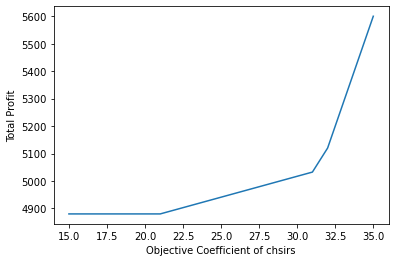

In [21]:
plt.plot('Obj Coeff', 'Obj', data=df)
plt.xlabel('Objective Coefficient of chsirs')
plt.ylabel('Total Profit')

We reset the objective coefficient of chairs to 16. Then, we alter the machining capacity versus total profit

In [26]:
column_labels = ['Capacity']
column_labels.extend(v.VarName for v in lv)
column_labels.append('Obj')
df = pd.DataFrame(columns = column_labels)

C.Obj = 16
for MCapacity in range(1200, 2001, 50):
    machining.RHS = MCapacity
    m.optimize()
    data = []
    data.append(MCapacity)
    for v in lv:
        data.append(v.X)
    data.append(m.ObjVal)
    df.loc[len(df.index)] = data
print(df)

    Capacity          C      D           T          Obj
0     1200.0   0.000000    0.0  300.000000  4200.000000
1     1250.0   0.000000    0.0  312.500000  4375.000000
2     1300.0   0.000000    0.0  325.000000  4550.000000
3     1350.0   0.000000   25.0  300.000000  4700.000000
4     1400.0   0.000000  100.0  200.000000  4800.000000
5     1450.0   0.000000  175.0  100.000000  4900.000000
6     1500.0   7.619048  170.0  102.857143  4961.904762
7     1550.0  17.142857  145.0  131.428571  5014.285714
8     1600.0  26.666667  120.0  160.000000  5066.666667
9     1650.0  36.190476   95.0  188.571429  5119.047619
10    1700.0  45.714286   70.0  217.142857  5171.428571
11    1750.0  55.238095   45.0  245.714286  5223.809524
12    1800.0  64.761905   20.0  274.285714  5276.190476
13    1850.0  72.380952    0.0  297.142857  5318.095238
14    1900.0  72.380952    0.0  297.142857  5318.095238
15    1950.0  72.380952    0.0  297.142857  5318.095238
16    2000.0  72.380952    0.0  297.142857  5318

Text(0, 0.5, 'Total Profit')

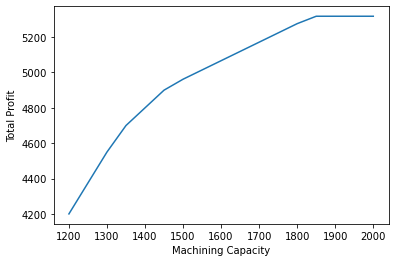

In [27]:
plt.plot('Capacity', 'Obj', data=df)
plt.xlabel('Machining Capacity')
plt.ylabel('Total Profit') #decreasing marginal uniy

The above plot shows us that there are decreasing marginal returns from increase in capacity of a resource.